# Lights model tutorial

In [1]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lights.simulation import SimuJointLongitudinalSurvival
from lights.base.utils import heatmap, annotate_heatmap, gompertz_pdf, \
                              gompertz_survival, visualize_vect_learning, visualize_vect_per_group
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
import seaborn as sns
%matplotlib inline

def printmd(string):
    display(Markdown(string))

In [2]:
## Load configuration
import json
with open('experiment.json') as f:
    conf = json.load(f)
print(json.dumps(conf, indent=4))

{
    "l_pen_EN": 0.08,
    "l_pen_SGL": 0.08,
    "eta_sp_gp_l1": 0.3,
    "max_iter": 10,
    "max_iter_lbfgs": 50,
    "max_iter_proxg": 50,
    "std_error": 2,
    "n_samples": 400,
    "n_MC": 50,
    "coeff_val_asso_low_risk": 0.1,
    "coeff_val_asso_high_risk": 0.1,
    "fixed_effect_mean_low_risk": [
        -0.8,
        0.2
    ],
    "fixed_effect_mean_high_risk": [
        1.5,
        0.8
    ],
    "cov_corr_long": 0.1,
    "sparsity": 0.5,
    "baseline_shape": 0.05,
    "baseline_scale": 0.01,
    "cov_corr_rdn_long": 0.05
}


## Generate data

In [3]:
n_long_features = 5
n_time_indep_features = 10
simu = SimuJointLongitudinalSurvival(seed=123, n_long_features=n_long_features, n_samples=conf["n_samples"],
                                     n_time_indep_features = n_time_indep_features, std_error=conf["std_error"],
                                     coeff_val_asso_low_risk=conf["coeff_val_asso_low_risk"],
                                     coeff_val_asso_high_risk=conf["coeff_val_asso_high_risk"],
                                    fixed_effect_mean_low_risk=conf["fixed_effect_mean_low_risk"],
                                    fixed_effect_mean_high_risk=conf["fixed_effect_mean_high_risk"],
                                     cov_corr_long = conf["cov_corr_long"], sparsity = conf["sparsity"],
                                     shape = conf["baseline_shape"], scale = conf["baseline_scale"])
X, Y, T, delta, S_k = simu.simulate()

printmd("\nLevel of censoring: **%.1f%%**" % (100*(1 - delta.mean())))
printmd("\nLevel of high-risk group: **%.1f%%**" % (100*(1 - simu.G.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.97e+00 seconds.



Level of censoring: **34.2%**


Level of high-risk group: **49.3%**

### Visualize parameter vectors
We generate survival times with a risk model of the form
$$\begin{align*}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align*}$$

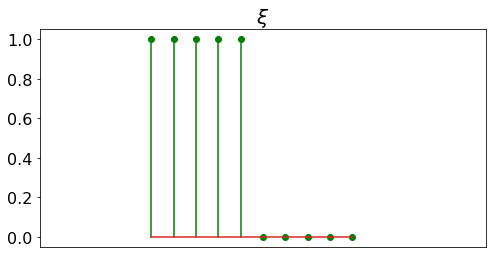

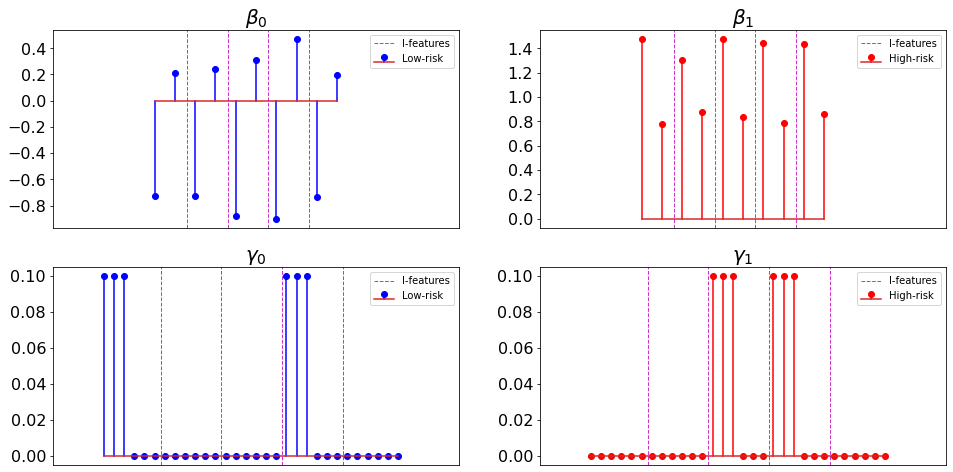

In [4]:
xi, betas, gammas = simu.time_indep_coeffs, simu.fixed_effect_coeffs, simu.asso_coeffs

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1

for i, vectors in enumerate([betas, gammas]):
    for k in [0, 1]:
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
        visualize_vect_per_group(vectors[k], n_long_features, ax)
plt.show()

### Visualize simulated times

We choose a Gompertz distribution for the baseline, that is
$$\lambda_0(t) = \kappa_1 \kappa_2 \exp(\kappa_2t)$$
with $\kappa_1 > 0$ and $\kappa_2 \in R$ the scale and shape parameters respectively.

kappa_1=0.01, kappa_2=0.05


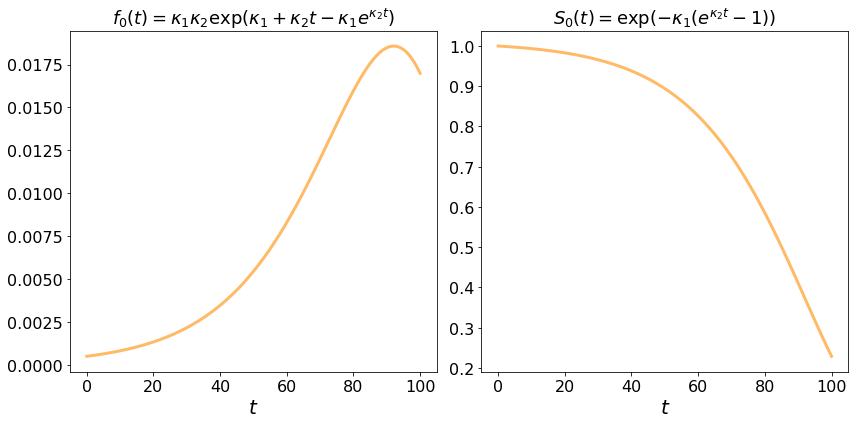

In [5]:
scale, shape = simu.scale, simu.shape
print("kappa_1=%s, kappa_2=%s" % (scale, shape))

fig = plt.figure(figsize=(12, 6))
# Density function plot
ax = fig.add_subplot(121)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_pdf(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$f_0(t) = \kappa_1 \kappa_2 \exp (\kappa_1 + \kappa_2 t -\kappa_1 e^{\kappa_2 t})$", 
          size=fontsize+2)

# Survival function plot
ax = fig.add_subplot(122)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_survival(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$S_0(t) = \exp (-\kappa_1 (e^{\kappa_2 t} - 1) )$", size=fontsize+2)

fig.tight_layout()
plt.show()

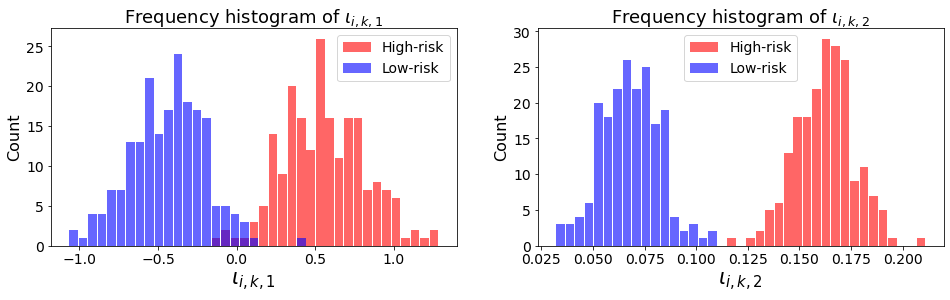

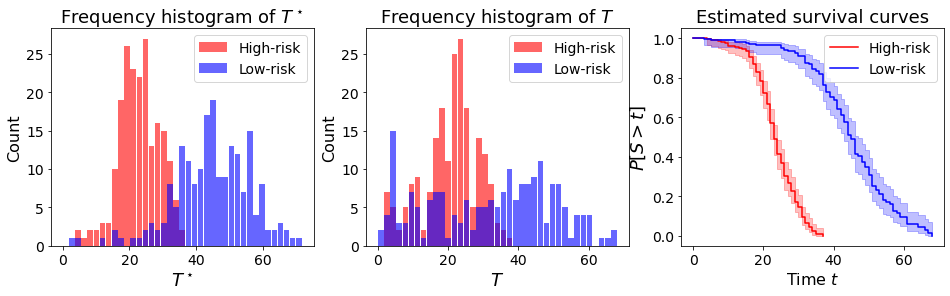

In [6]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize longitudinal processes for two subjects randomly chosen

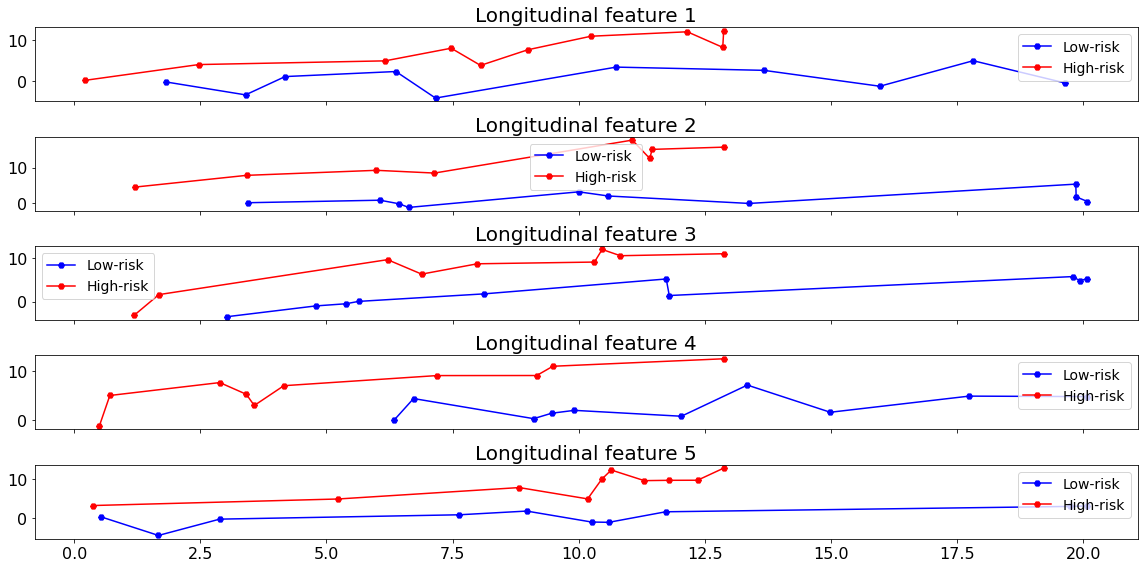

In [7]:
np.random.seed(10)
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(n_long_features,1,1)
colors, labels = ['b', 'r'], ['Low-risk', 'High-risk']
for k in [0, 1]:
    idx = np.random.choice(Y[G == k].index)
    Y_i = Y.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(1, n_long_features + 1):
        Y_il = Y_i["long_feature_%s" % l]
        ax = plt.subplot(n_long_features,1 ,l , sharex=ax0)
        Y_il.plot(label=label, color=color, marker='H')
        ax.set_title("Longitudinal feature %s" % l, fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

## Data splitting

In [8]:
# Split data into training and test sets 
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    Y_test = Y.iloc[test_index, :]
    T_test = T[test_index]
    delta_test = delta[test_index]

    X_train = X[train_index]
    Y_train = Y.iloc[train_index, :]
    T_train = T[train_index]
    delta_train = delta[train_index]
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Training 

Launching the solver prox_QNMCEM...
Launching the solver MLMM...
Launching the solver ULMM...
Done solving using ULMM in 3.96e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  29565.7 |      inf
       1 |  27615.1 | 6.60e-02
       2 |  27536.7 | 2.84e-03
       3 |  27509.4 | 9.90e-04
       4 |  27495.6 | 5.01e-04
       5 |  27487.5 | 2.95e-04
       6 |  27482.2 | 1.94e-04
       7 |  27478.4 | 1.37e-04
       8 |  27475.6 | 1.03e-04
       9 |  27473.4 | 8.04e-05
      10 |  27471.6 | 6.51e-05
Done solving using MLMM in 6.12e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  134.566 |      inf
       1 |  115.848 | 1.39e-01
       2 |  103.783 | 1.04e-01
       3 |  103.177 | 5.84e-03
       4 |  103.222 | 4.33e-04
       5 |  103.094 | 1.24e-03
       6 |  103.202 | 1.04e-03
       7 |  102.935 | 2.59e-03
       8 |  102.935 | 1.28e-06
       9 |  102.735 | 1.94e-03
      10 |  102.762 | 2.60e-04
Done solving using prox_QNMCEM in 4.12e+02 seconds


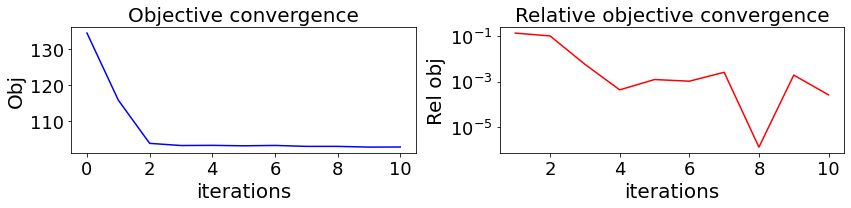

In [9]:
from lights.inference import prox_QNMCEM

## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

learner = prox_QNMCEM(fixed_effect_time_order=1, max_iter=conf["max_iter"],
                      max_iter_lbfgs=conf["max_iter_lbfgs"], 
                      max_iter_proxg=conf["max_iter_proxg"], compute_obj=True, print_every=1,
                      l_pen_SGL=conf["l_pen_SGL"], eta_sp_gp_l1=conf["eta_sp_gp_l1"], 
                      asso_functions=["lp", "re"], l_pen_EN=conf["l_pen_EN"],
                      initialize=True)
if learner.simu:
    learner.fit(X_train, Y_train, T_train, delta_train, S_k, conf["cov_corr_rdn_long"])
else:
    learner.fit(X_train, Y_train, T_train, delta_train)
    

# Visualize learning
visualize_vect_learning(learner, "obj")

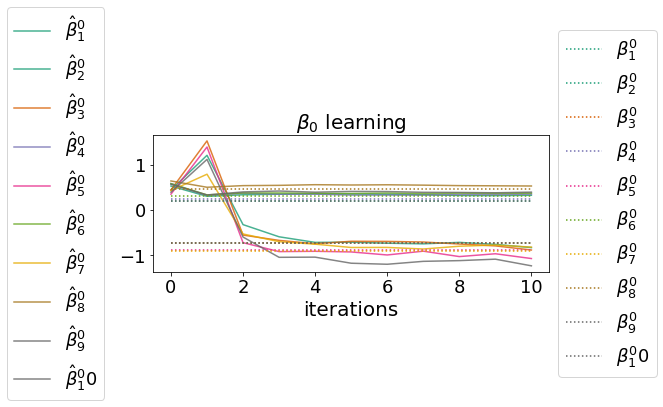

In [10]:
# Visualize beta_0
true_beta_0 = simu.fixed_effect_coeffs[0].reshape(-1, 1)
to = len(true_beta_0)+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "beta_0", r"$\beta_0$", true_beta_0, leg1, leg2)

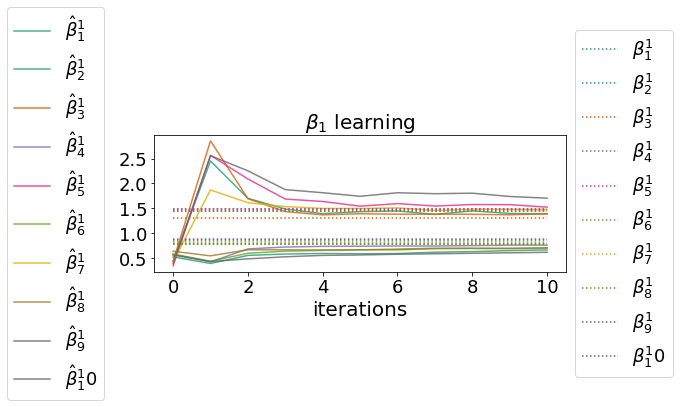

In [11]:
# Visualize beta_1
true_beta_1 = simu.fixed_effect_coeffs[1].reshape(-1, 1)
to = len(true_beta_1)+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "beta_1", r"$\beta_1$", true_beta_1, leg1, leg2)

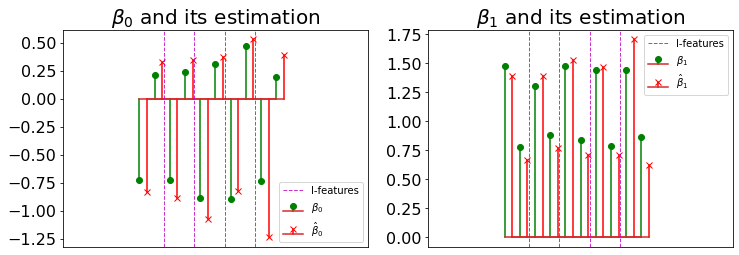

In [12]:
beta_0_true = true_beta_0
beta_0_est = learner.theta["beta_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(beta_0_true)).tolist(), beta_0_true, linefmt='g-', markerfmt='go', label= r"$\beta_0$")
ax.stem((np.arange(len(beta_0_est)) + .5).tolist(), beta_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_0$")
ax.set_xlim([-5, len(beta_0_true) + 5])
ax.set_title(r"$\beta_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(beta_0_true, n_long_features, ax)

beta_1_true = true_beta_1
beta_1_est = learner.theta["beta_1"]
fontsize = 16
ax = fig.add_subplot(122)
ax.stem(np.arange(len(beta_1_true)).tolist(), beta_1_true, linefmt='g-', markerfmt='go', label= r"$\beta_1$")
ax.stem((np.arange(len(beta_1_est)) + .5).tolist(), beta_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_1$")
ax.set_xlim([-5, len(beta_1_true) + 5])
ax.set_title(r"$\beta_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(beta_1_true, n_long_features, ax)
plt.show()

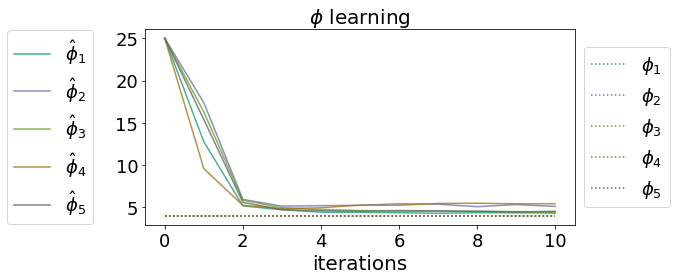

In [13]:
# Visualize phi
true_phi = np.array([simu.std_error ** 2] * simu.n_long_features).reshape(-1, 1)
to = len(true_phi)+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "phi", symbol = r"$\phi$", true_coeffs = true_phi, legend_est = leg1, legend_true = leg2)

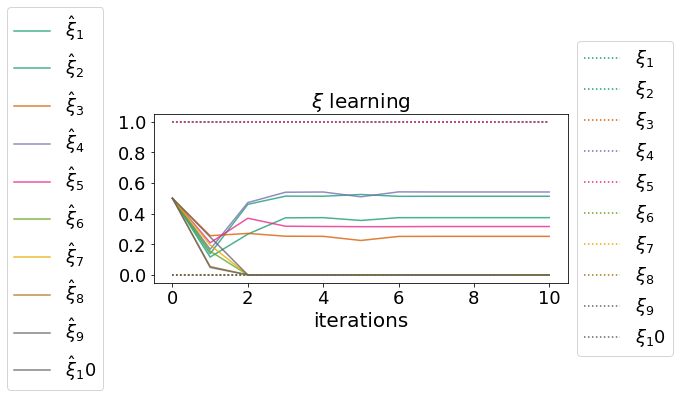

In [14]:
# Visualize xi
true_xi = simu.time_indep_coeffs.reshape(-1, 1)
to = len(true_xi)+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "xi", r"$\xi$", true_xi, leg1, leg2)

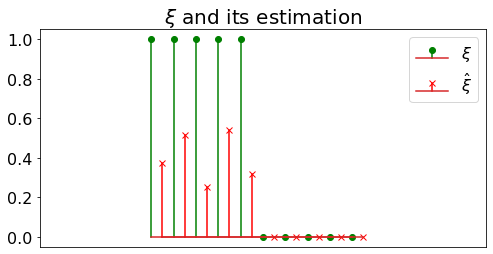

In [15]:
xi_true = true_xi
xi_est = learner.theta["xi"]
fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(np.arange(len(xi_true)).tolist(), true_xi, linefmt='g-', markerfmt='go', label= r"$\xi$")
ax.stem((np.arange(len(xi_est)) + .5).tolist(), xi_est, linefmt='r-', markerfmt='rx', label= r"$\hat \xi$")
ax.set_xlim([-5, len(true_xi) + 5])
ax.set_title(r"$\xi$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

## NOTE:
$\gamma'$ is optimized by Copt solver without adding the intercept (ones column vector).

$\gamma$ is denormalized by the its feature standard deviation.
$$\gamma = \frac{\gamma'}{std(\Psi)} $$
with $\Psi$ denotes the association features vector.

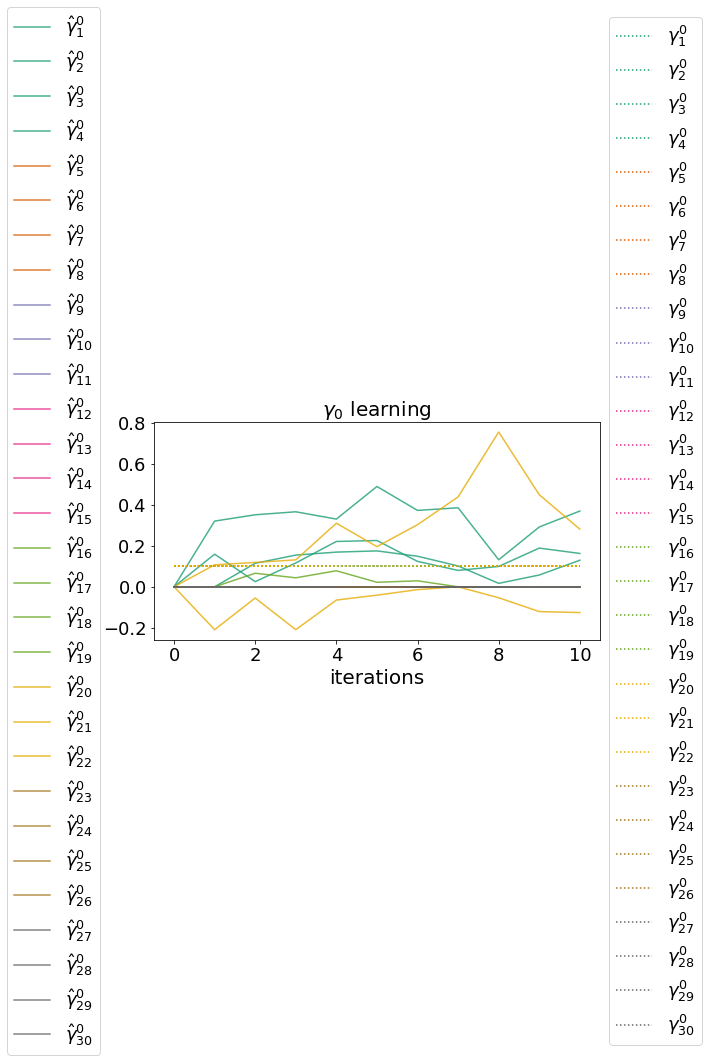

In [16]:
# Visualize gamma_0
true_gamma_0 = simu.asso_coeffs[0].reshape(-1, 1)
to = len(true_gamma_0)+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(learner, "gamma_0", r"$\gamma_0$", true_gamma_0, leg1, leg2)

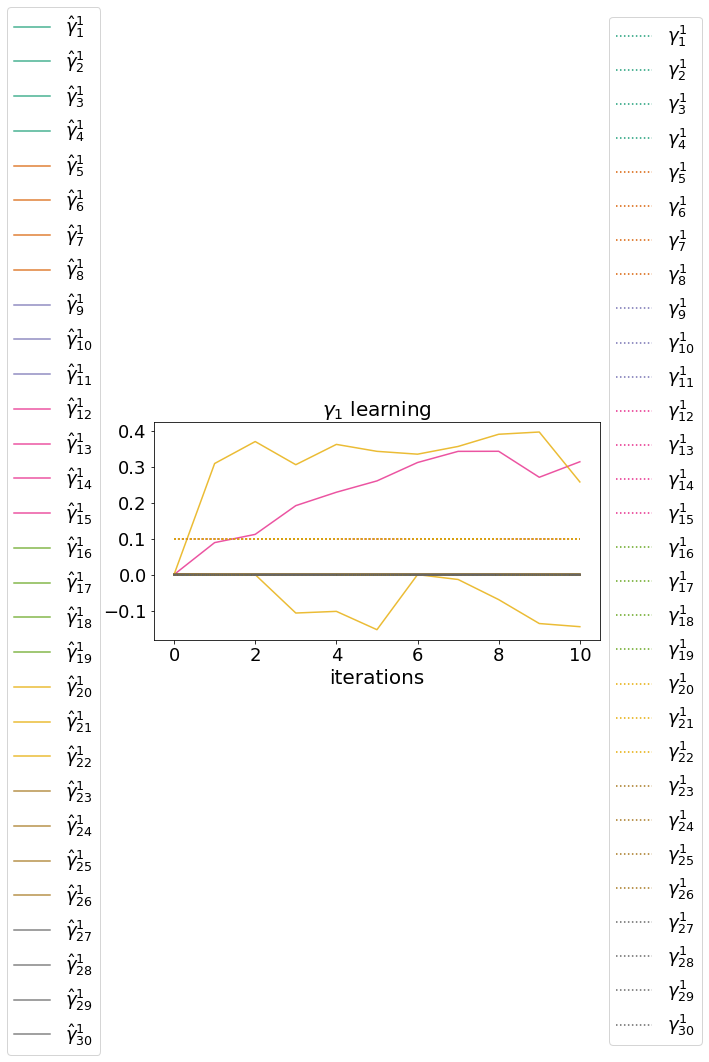

In [17]:
# Visualize gamma_1
true_gamma_1 = simu.asso_coeffs[1].reshape(-1, 1)
to = len(true_gamma_1)+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(learner, "gamma_1", r"$\gamma_1$", true_gamma_1, leg1, leg2)

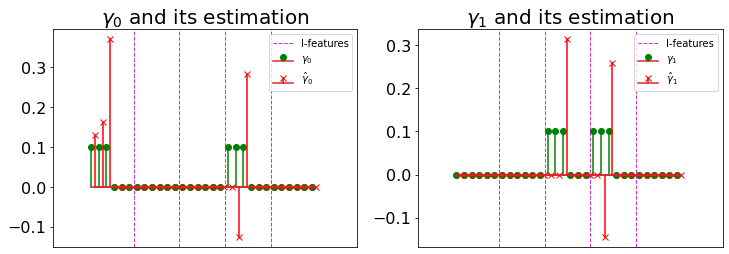

In [18]:
gamma_0_true = true_gamma_0
gamma_0_est = learner.theta["gamma_0"]

fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(gamma_0_true)).tolist(), gamma_0_true, linefmt='g-', markerfmt='go', label= r"$\gamma_0$")
ax.stem((np.arange(len(gamma_0_est)) + .5).tolist(), gamma_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_0$")
ax.set_xlim([-5, len(true_gamma_0) + 5])
ax.set_title(r"$\gamma_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(gamma_0_true, n_long_features, ax)

gamma_1_true = true_gamma_1
gamma_1_est = learner.theta["gamma_1"]
ax = fig.add_subplot(122)
ax.stem(np.arange(len(gamma_1_true)).tolist(), gamma_1_true, linefmt='g-', markerfmt='go', label= r"$\gamma_1$")
ax.stem((np.arange(len(gamma_1_est)) + .5).tolist(), gamma_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_1$")
ax.set_xlim([-5, len(true_gamma_1) + 5])
ax.set_title(r"$\gamma_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(gamma_1_true, n_long_features, ax)
plt.show()

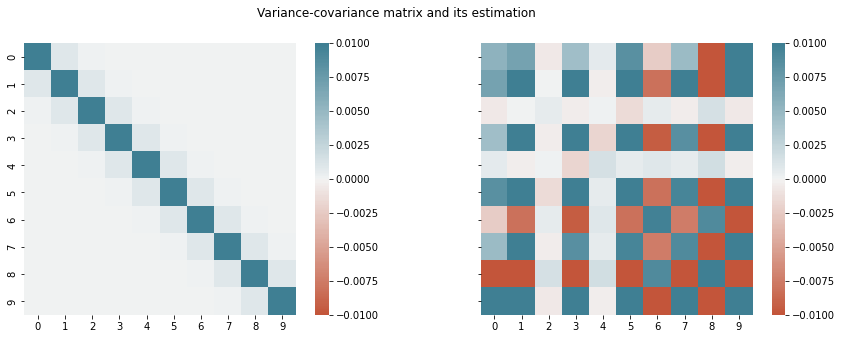

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Variance-covariance matrix and its estimation')

sns.heatmap(
    data=simu.long_cov, 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[0]
)

sns.heatmap(
    data=learner.theta["long_cov"], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[1]
)

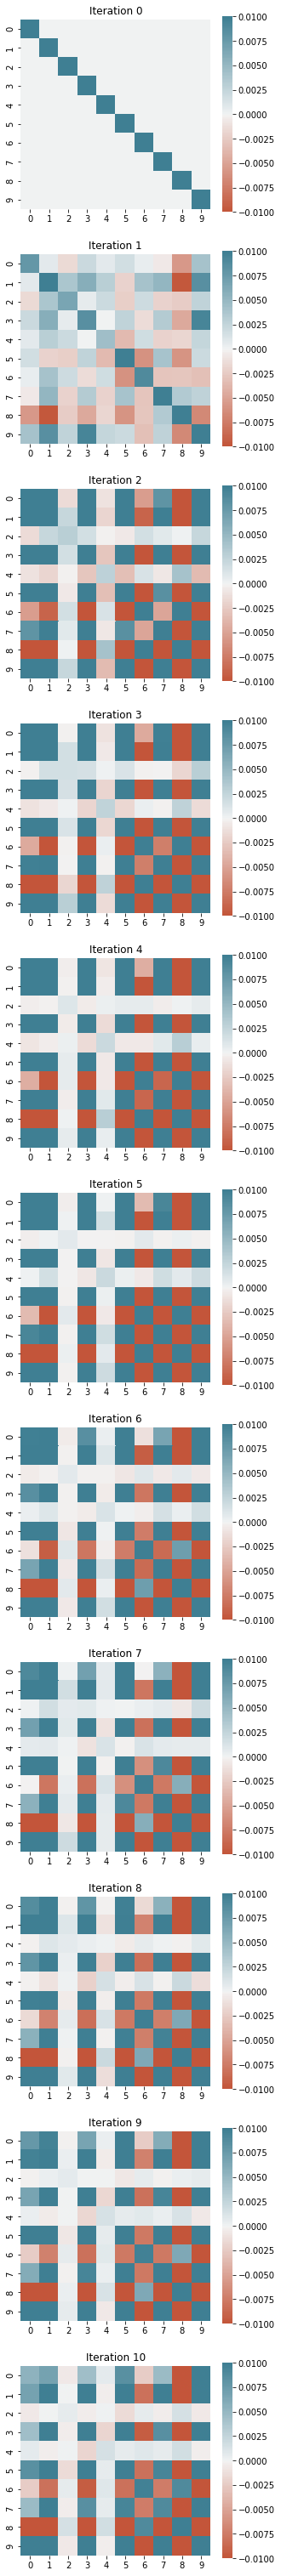

In [20]:
long_cov_history = learner.history.values["long_cov"]
fig, axes = plt.subplots(len(long_cov_history), 1, figsize=(5, 5 * len(long_cov_history)), sharey=True)
for i in range(len(long_cov_history)):
    sns.heatmap(
    data=long_cov_history[i], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[i]
    )
    axes[i].set_title("Iteration {}".format(i))

<function matplotlib.pyplot.show(*args, **kw)>

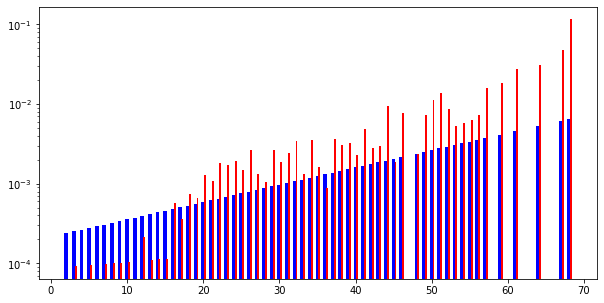

In [21]:
times = learner.theta["baseline_hazard"].index.values
est_value = learner.theta["baseline_hazard"].values
true_value = (simu.scale * simu.shape) * np.exp(simu.shape * times)
non_zero_idx = np.argwhere(est_value != 0)
ratio = np.mean(true_value[non_zero_idx] / est_value[non_zero_idx])
fig = plt.figure(figsize=(10, 5))
plt.bar(times, np.log10(1 + true_value), color = 'b', width = 0.5)
plt.bar(times + 0.25, np.log10(1 + est_value * ratio), color = 'r', width = 0.25)
plt.yscale('log')
plt.show

## Prediction

In [22]:
# evalutation here
marker_train = learner.predict_marker(X_train, Y_train)
c_index_train = c_index_score(T_train, marker_train, delta_train)
c_index_train = max(c_index_train, 1 - c_index_train)

## Obtain the marker vector on test set ##

# prediction here
marker_test = learner.predict_marker(X_test, Y_test)
c_index_test = c_index_score(T_test, marker_test, delta_test)
c_index_test = max(c_index_test, 1 - c_index_test)

print("Done predicting on dataset.")
print("C-index on train: %.2f" % c_index_train)
print("C-index on test: %.2f" % c_index_test)

Done predicting on dataset.
C-index on train: 0.76
C-index on test: 0.76


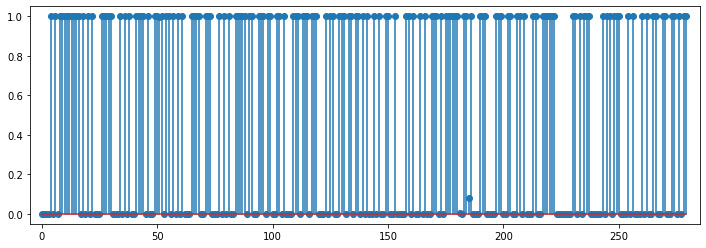

In [23]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
ax.stem(np.arange(len(marker_train)).tolist(), marker_train)
ax.set_xlim([-5, len(marker_train) + 5])
plt.show()

## Figures

### Learning curves